In [1]:
import pandas as pd

from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine

from datetime import date, timedelta
from pathlib import Path

import numpy as np

In [2]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import math

In [4]:
pd.set_option('display.max_columns', None)

# Банки

Забираем инфу по отзывам за последние 5 лет (период динамический)

In [5]:
query = '''
	SELECT DISTINCT
		R.ID,
		CAST(R."DATE" AS date) AS "DATE",
		R.USERID,
		ORM."NAME" AS ORGANIZATION_NAME,
		ORM.ALIAS AS ORGANIZATION_ALIAS,
		CASE 
			WHEN R.REVIEWOBJECTTYPEID = 1 THEN 'Banks'
			WHEN R.REVIEWOBJECTTYPEID = 6 THEN 'InsuranceCompany'
			WHEN R.REVIEWOBJECTTYPEID = 10 THEN 'MFI'
			ELSE NULL
		END AS REVIEW_OBJECT_TYPE,
		R.PARENT,
		R.ROOT,
		R.RATING,
		R.RATINGCOUNTED,
		R.COUNTEDRATING,
		CASE 
			WHEN COUNTEDRATING IN (1, 2) THEN 1
			ELSE NULL
		END	AS BAD_REVIEWS,
		CASE 
			WHEN COUNTEDRATING IN (3, 4, 5) THEN 1
			ELSE NULL
		END AS GOOD_REVIEWS,
		R.PROBLEMSOLVED,
		R.PROBLEMSOLUTIONDATE,
		R.ISRECOMMENDEDBYUSER,
		R.MODERATIONREASON,
		R.UTMSOURCE || '|' || R.UTMMEDIUM SOURCE_MEDIUM,
		R.COMMENTSCOUNT,
		R.HASCOMPANYRESPONSE,
		R.MODERATIONREASON
	FROM ODS_BATCH.REVIEWS.REVIEWS R
	LEFT JOIN ODS_BATCH.REVIEWS.ORGANIZATIONREADMODELS ORM
		ON R.REVIEWOBJECTID = ORM.ID
	WHERE R.REVIEWOBJECTTYPEID = 1
	AND "DATE" >= DATEADD(year, -5, CURRENT_DATE())
	AND PARENT IS NULL
	AND RATINGCOUNTED = 1
	AND R.COUNTEDRATING IN (1, 2, 3, 4, 5)
    '''

Подключаемся к SF

In [6]:
engine = create_engine(URL(
        account='ic70009.west-europe.azure',
        user='nastya_stefanova',
        password='***',
        database='ODS_BATCH',
        schema='FORMBUILDER',
        warehouse='SELECTOR',
        role='analyst',
    ))

In [7]:
rank_data = pd.io.sql.read_sql(query, con = engine)

In [8]:
rank_data.head()

,id,date,userid,organization_name,organization_alias,review_object_type,parent,root,rating,ratingcounted,countedrating,bad_reviews,good_reviews,problemsolved,problemsolutiondate,isrecommendedbyuser,moderationreason,source_medium,commentscount,hascompanyresponse,moderationreason
0,205883,2016-07-21,68263.0,Кредит Европа Банк,kredit-evropa-bank,Banks,None,205883.0,1,True,1,1.0,NaN,False,NaT,None,0,yandex|organic,2,True,0
1,208967,2016-08-11,71301.0,Московский Кредитный Банк,moskovskij-kreditnyj-bank,Banks,None,208967.0,5,True,5,NaN,1.0,False,NaT,None,0,yandex|organic,1,True,0
2,198795,2016-04-19,60044.0,Бинбанк Диджитал,binbank-didzhital,Banks,None,198795.0,1,True,1,1.0,NaN,False,NaT,None,0,None,1,True,0
3,200022,2016-05-10,62739.0,Бинбанк,binbank,Banks,None,200022.0,1,True,1,1.0,NaN,False,NaT,None,0,google|organic,1,True,0
4,205944,2016-07-22,68320.0,Ханты-Мансийский банк Открытие,khanty-mansijskij-bank-otkrytie,Banks,None,205944.0,1,True,1,1.0,NaN,False,NaT,None,0,yandex|organic,0,False,0


In [9]:
rank_data['date'] = pd.to_datetime(rank_data['date'])

rank_data['year'] = rank_data['date'].dt.year

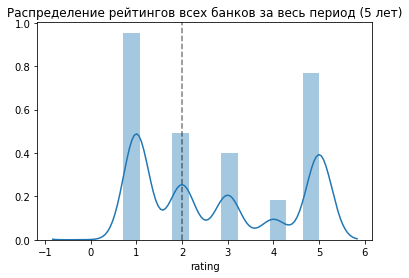

In [10]:
sns.distplot(rank_data['rating'])
median_value = rank_data['rating'].median()
plt.axvline(median_value, color='black', linestyle='--', alpha=0.5);
plt.title('Распределение рейтингов всех банков за весь период (5 лет)');

Считаем количество дней от даты отзыва до сегодняшнего дня:

In [11]:
today = pd.to_datetime(date.today())
today

rank_data['days_to_today'] = today -  rank_data['date']

rank_data['days_to_today'] = rank_data['days_to_today'].dt.days

Рассчитываем временной коэффициент
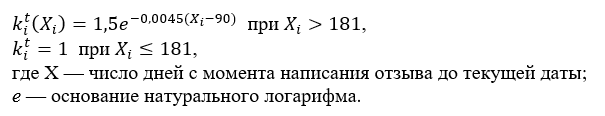

In [12]:
def time_koef(days):
    if days > 181:
        k = 1.5*(math.e**(-0.0045*(days-90)))
    if days <= 181:
        k = 1
    return k

Какие значения принимает временной коэффициент, примеры:

In [13]:
time_koef_example = pd.DataFrame(data = {'days': [90, 181, 182, 270,365,540,720]})
time_koef_example['time_koef'] = time_koef_example['days'].apply(time_koef)

In [14]:
time_koef_example

,days,time_koef
0,90,1.000000
1,181,1.000000
2,182,0.991501
3,270,0.667287
4,365,0.435163
5,540,0.197991
6,720,0.088078


Применяем временной коэффициент:

In [15]:
rank_data['time_koef'] = rank_data['days_to_today'].apply(time_koef)

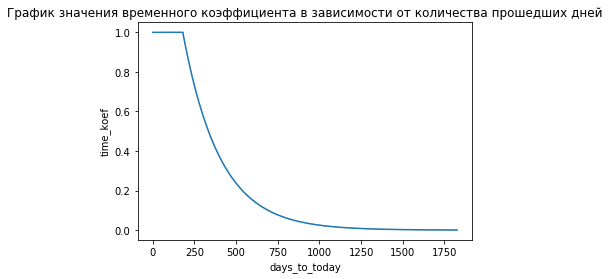

In [16]:
sns.lineplot(x='days_to_today',y='time_koef',data=rank_data);
plt.title('График значения временного коэффициента в зависимости от количества прошедших дней');

Функция для добавления доп параметров:

In [17]:
def extra_params(data,rating_column,ploblem_solved_koef,has_response_koef):
    data[rating_column] = data[rating_column] + ploblem_solved_koef * data['problemsolved'] + has_response_koef * data['hascompanyresponse']

Применяем доп параметры: 1 балл за решение проблемы, 0.5 за официальный ответ

In [18]:
extra_params(rank_data,'countedrating',1,0.5)

Считаем финальный рейтинг с учетом всех коэффициентов:

In [19]:
rank_data['final_rating'] = (rank_data['countedrating'] * rank_data['time_koef'])

Рассчитываем данные по банкам за последние 12 месяцев:

In [20]:
last_12_months = (rank_data.query('days_to_today <= 365')
                           .groupby('organization_name')
                           .agg({'ratingcounted':'count',
                                'final_rating':'sum',
                                'time_koef':'sum',
                                'problemsolved':'sum',
                             'hascompanyresponse':'sum'})
                           .reset_index()
                 )
last_12_months.columns = ['bank_name','num_reviews','sum_rating','sum_time_koef','num_problem_solved', 'num_comp_resp']
last_12_months = last_12_months.sort_values(by='num_reviews')
last_12_months['individual_rating'] = last_12_months['sum_rating']/last_12_months['sum_time_koef']
last_12_months

,bank_name,num_reviews,sum_rating,sum_time_koef,num_problem_solved,num_comp_resp,individual_rating
0,Bank of China,1,1.000000,1.000000,0.0,0.0,1.000000
30,Евроальянс,1,2.000000,1.000000,0.0,0.0,2.000000
31,Еврофинанс Моснарбанк,1,2.529641,0.843214,0.0,0.0,3.000000
36,Индустриальный сберегательный Банк,1,1.000000,1.000000,0.0,0.0,1.000000
37,Интерпрогрессбанк,1,5.000000,1.000000,0.0,0.0,5.000000
...,...,...,...,...,...,...,...
21,ВТБ,183,320.135990,157.168719,3.0,0.0,2.036894
94,Тинькофф Банк,184,801.631672,171.847214,59.0,182.0,4.664793
90,Совкомбанк,200,797.763203,166.425962,37.0,196.0,4.793502
87,Сбербанк,220,518.947699,193.373977,4.0,0.0,2.683648


In [21]:
print('Количество банков, по которым был хотя бы 1 отзыв в последние 12 месяцев: {}'.format(len(last_12_months)))
print('Количество банков с 1 отзывом за последние 12 месяцев: {}, что составляет {:.2%}'.format(len(last_12_months.query('num_reviews == 1')),len(last_12_months.query('num_reviews == 1'))/len(last_12_months)))
print('Количество банков с менее 10 отзывами за последние 12 месяцев: {}, что составляет {:.2%}'.format(len(last_12_months.query('num_reviews < 10')),len(last_12_months.query('num_reviews < 10'))/len(last_12_months)))
print('Количество банков, по которым было более 10 отзывов (включительно) в последние 12 месяцев: {}'.format(len(last_12_months.query('num_reviews >= 10'))))

Количество банков, по которым был хотя бы 1 отзыв в последние 12 месяцев: 116
Количество банков с 1 отзывом за последние 12 месяцев: 33, что составляет 28.45%
Количество банков с менее 10 отзывами за последние 12 месяцев: 76, что составляет 65.52%
Количество банков, по которым было более 10 отзывов (включительно) в последние 12 месяцев: 40


### Последующий расчет рейтинга и ранжирование будет происходить только для банков с 10 и более отзывами за последние 12 месяцев!

Для этого формируем список банков:

In [22]:
banks_list = last_12_months.query('num_reviews >= 10')['bank_name'].to_list()

#### Вариант 1.  Рейтинг считается на основании всех данных за последние 5 лет (динамический период).

Группируем информацию по банкам (по выделенному списку банков):

In [23]:
rank_data['date_double'] = rank_data['date']
banks_data = (rank_data.query('organization_name in @banks_list')
                       .groupby('organization_name')
                       .agg({'final_rating':'sum',
                             'time_koef':'sum',
                             'ratingcounted':'count',
                             'problemsolved':'sum',
                             'hascompanyresponse':'sum',
                             'date':'min',
                             'date_double':'max'
                            }
                             )
             ) 

#считаем средневзвешанный рейтинг с учетом весов (временного коэффициента)
banks_data['mean_rating'] = banks_data['final_rating']/banks_data['time_koef']
banks_data = banks_data.sort_values(by=['mean_rating','ratingcounted'], ascending=False)
banks_data.columns = ['sum_rating','sum_time_koef','num_reviews', 'num_problem_solved', 'num_comp_resp','first_review_date','last_review_date','individual_rating']
banks_data.head()

,sum_rating,sum_time_koef,num_reviews,num_problem_solved,num_comp_resp,first_review_date,last_review_date,individual_rating
organization_name,,,,,,,,
Развитие-столица,58.965738,11.250599,13,0.0,6.0,2019-02-04,2021-02-09,5.241120
Заубер Банк,175.891716,34.650173,38,0.0,14.0,2016-11-08,2021-03-16,5.076215
Центр-инвест,414.390464,85.826646,222,2.0,0.0,2016-04-14,2021-03-13,4.828226
Энергомашбанк,125.632080,26.282218,44,2.0,0.0,2016-05-24,2021-01-27,4.780117
Кольцо Урала,90.633578,19.036581,22,0.0,0.0,2016-08-24,2020-09-30,4.761022


Расчитываем рейтинг по формуле Байеса:
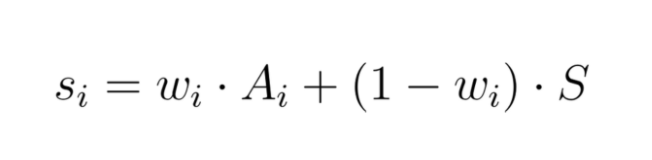

где 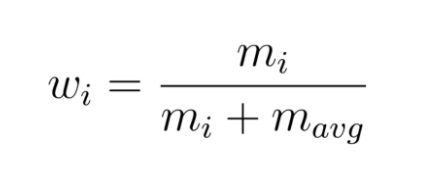

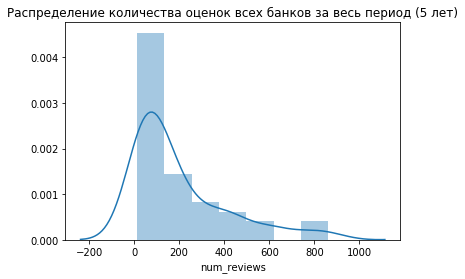

In [24]:
sns.distplot(banks_data['num_reviews']);
plt.title('Распределение количества оценок всех банков за весь период (5 лет)');

In [25]:
m_avg = banks_data['num_reviews'].median()
m_avg

99.5

In [26]:
m_i = banks_data['num_reviews']

In [27]:
banks_data['w'] = m_i/(m_i+m_avg)
w = banks_data['w']

In [28]:
S = banks_data['sum_rating'].sum()/banks_data['sum_time_koef'].sum()
S

3.544716442981085

In [29]:
A_i = banks_data['individual_rating']

In [30]:
banks_data['bayes_rating'] = (w * A_i 
                              + (1-w) * S
                             )

In [31]:
banks_data.sort_values('bayes_rating',ascending=False)

,sum_rating,sum_time_koef,num_reviews,num_problem_solved,num_comp_resp,first_review_date,last_review_date,individual_rating,w,bayes_rating
organization_name,,,,,,,,,,
Совкомбанк,971.509693,204.382837,456,71.0,451.0,2016-03-28,2021-03-15,4.753382,0.820882,4.536888
Центр-инвест,414.390464,85.826646,222,2.0,0.0,2016-04-14,2021-03-13,4.828226,0.690513,4.430997
Тинькофф Банк,884.589147,192.698959,441,109.0,427.0,2016-03-25,2021-03-17,4.590524,0.815911,4.398002
Банк «Санкт-Петербург»,189.911543,40.620719,98,4.0,20.0,2016-04-05,2021-03-16,4.675238,0.496203,4.105684
Модульбанк,148.228507,31.621959,94,1.0,0.0,2016-05-04,2021-02-26,4.687518,0.485788,4.099876
ФК Открытие,1328.335702,319.834979,592,95.0,0.0,2016-07-29,2021-03-17,4.153191,0.856110,4.065637
Заубер Банк,175.891716,34.650173,38,0.0,14.0,2016-11-08,2021-03-16,5.076215,0.276364,3.967967
Газпромбанк,709.379140,173.977373,309,138.0,278.0,2016-04-12,2021-03-13,4.077422,0.756426,3.947669
Энергомашбанк,125.632080,26.282218,44,2.0,0.0,2016-05-24,2021-01-27,4.780117,0.306620,3.923515


banks_data.to_excel("bayes_1_new.xlsx")

# Страховые

In [32]:
query_ins = '''
	SELECT DISTINCT
		R.ID,
		CAST(R."DATE" AS date) AS "DATE",
		R.USERID,
		ORM."NAME" AS ORGANIZATION_NAME,
		ORM.ALIAS AS ORGANIZATION_ALIAS,
		CASE 
			WHEN R.REVIEWOBJECTTYPEID = 1 THEN 'Banks'
			WHEN R.REVIEWOBJECTTYPEID = 6 THEN 'InsuranceCompany'
			WHEN R.REVIEWOBJECTTYPEID = 10 THEN 'MFI'
			ELSE NULL
		END AS REVIEW_OBJECT_TYPE,
		R.PARENT,
		R.ROOT,
		R.RATING,
		R.RATINGCOUNTED,
		R.COUNTEDRATING,
		CASE 
			WHEN COUNTEDRATING IN (1, 2) THEN 1
			ELSE NULL
		END	AS BAD_REVIEWS,
		CASE 
			WHEN COUNTEDRATING IN (3, 4, 5) THEN 1
			ELSE NULL
		END AS GOOD_REVIEWS,
		R.PROBLEMSOLVED,
		R.PROBLEMSOLUTIONDATE,
		R.ISRECOMMENDEDBYUSER,
		R.MODERATIONREASON,
		R.UTMSOURCE || '|' || R.UTMMEDIUM SOURCE_MEDIUM,
		R.COMMENTSCOUNT,
		R.HASCOMPANYRESPONSE,
		R.MODERATIONREASON
	FROM ODS_BATCH.REVIEWS.REVIEWS R
	LEFT JOIN ODS_BATCH.REVIEWS.ORGANIZATIONREADMODELS ORM
		ON R.REVIEWOBJECTID = ORM.ID
	WHERE R.REVIEWOBJECTTYPEID = 6
	AND "DATE" >= DATEADD(year, -5, CURRENT_DATE())
	AND PARENT IS NULL
	AND RATINGCOUNTED = 1
	AND R.COUNTEDRATING IN (1, 2, 3, 4, 5)
    '''

In [33]:
engine = create_engine(URL(
        account='ic70009.west-europe.azure',
        user='nastya_stefanova',
        password='***',
        database='ODS_BATCH',
        schema='FORMBUILDER',
        warehouse='SELECTOR',
        role='analyst',
    ))

In [34]:
rank_ins_data = pd.io.sql.read_sql(query_ins, con = engine)

In [35]:
rank_ins_data.head()

,id,date,userid,organization_name,organization_alias,review_object_type,parent,root,rating,ratingcounted,countedrating,bad_reviews,good_reviews,problemsolved,problemsolutiondate,isrecommendedbyuser,moderationreason,source_medium,commentscount,hascompanyresponse,moderationreason
0,258754,2017-11-30,242256.0,АльфаСтрахование,alfastrahovanie,InsuranceCompany,None,258754.0,1,True,1,1.0,NaN,True,NaT,None,0,yandex|organic,2,True,0
1,290274,2018-05-23,430314.0,АльфаСтрахование,alfastrahovanie,InsuranceCompany,None,NaN,3,True,3,NaN,1.0,True,2018-05-23 17:39:00.847,None,0,None,1,True,0
2,391602,2021-01-13,8492227.0,АльфаСтрахование,alfastrahovanie,InsuranceCompany,None,NaN,2,True,2,1.0,NaN,False,NaT,None,0,None,1,True,0
3,315293,2019-03-18,881910.0,АльфаСтрахование,alfastrahovanie,InsuranceCompany,None,NaN,1,True,1,1.0,NaN,True,2019-04-30 09:39:05.610,None,0,None,1,True,0
4,309700,2019-01-17,699071.0,АльфаСтрахование,alfastrahovanie,InsuranceCompany,None,NaN,2,True,2,1.0,NaN,True,2019-01-31 12:54:20.167,None,0,None,3,True,0


In [36]:
rank_ins_data['date'] = pd.to_datetime(rank_ins_data['date'])

rank_ins_data['year'] = rank_ins_data['date'].dt.year

In [37]:
today = pd.to_datetime(date.today())

rank_ins_data['days_to_today'] = today -  rank_ins_data['date']

rank_ins_data['days_to_today'] = rank_ins_data['days_to_today'].dt.days

In [38]:
def time_koef(days):
    if days > 181:
        k = 1.5*(math.e**(-0.0045*(days-90)))
    if days <= 181:
        k = 1
    return k

In [39]:
rank_ins_data['time_koef'] = rank_ins_data['days_to_today'].apply(time_koef)

In [40]:
def extra_params(data,rating_column,ploblem_solved_koef,has_response_koef):
    data[rating_column] = data[rating_column] + ploblem_solved_koef * data['problemsolved'] + has_response_koef * data['hascompanyresponse']

In [41]:
extra_params(rank_ins_data,'countedrating',1,0.5)

Считаем финальный рейтинг с учетом всех коэффициентов:

In [42]:
rank_ins_data['final_rating'] = (rank_ins_data['countedrating'] * rank_ins_data['time_koef'])

Рассчитываем данные по банкам за последние 12 месяцев:

In [43]:
last_12_months_ins = (rank_ins_data.query('days_to_today <= 365')
                           .groupby('organization_name')
                           .agg({'ratingcounted':'count',
                                'final_rating':'sum',
                                'time_koef':'sum',
                                'problemsolved':'sum',
                             'hascompanyresponse':'sum'})
                           .reset_index()
                 )
last_12_months_ins.columns = ['ins_name','num_reviews','sum_rating','sum_time_koef','num_problem_solved', 'num_comp_resp']
last_12_months_ins = last_12_months_ins.sort_values(by='num_reviews')
last_12_months_ins['individual_rating'] = last_12_months_ins['sum_rating']/last_12_months_ins['sum_time_koef']
last_12_months_ins

,ins_name,num_reviews,sum_rating,sum_time_koef,num_problem_solved,num_comp_resp,individual_rating
31,Мегарусс-Д,1,2.000000,1.000000,0.0,0.0,2.000000
23,Интери,1,0.791730,0.791730,0.0,0.0,1.000000
27,Каско-МС,1,1.000000,1.000000,0.0,0.0,1.000000
29,МАКС-М,1,1.000000,1.000000,0.0,0.0,1.000000
34,Надежда,1,1.000000,1.000000,0.0,0.0,1.000000
...,...,...,...,...,...,...,...
55,Согласие,126,488.266693,107.021291,13.0,122.0,4.562332
11,ВСК,146,291.142889,119.903195,8.0,0.0,2.428150
9,Астро-Волга,157,689.549865,131.725463,22.0,147.0,5.234750
42,Ренессанс Страхование,379,1696.382426,338.877049,75.0,372.0,5.005894


In [44]:
print('Количество страховых, по которым был хотя бы 1 отзыв в последние 12 месяцев: {}'.format(len(last_12_months_ins)))
print('Количество страховых с 1 отзывом за последние 12 месяцев: {}, что составляет {:.2%}'.format(len(last_12_months_ins.query('num_reviews == 1')),len(last_12_months_ins.query('num_reviews == 1'))/len(last_12_months_ins)))
print('Количество страховых с менее 10 отзывами за последние 12 месяцев: {}, что составляет {:.2%}'.format(len(last_12_months_ins.query('num_reviews < 10')),len(last_12_months_ins.query('num_reviews < 10'))/len(last_12_months_ins)))
print('Количество страховых, по которым было более 10 отзывов (включительно) в последние 12 месяцев: {}'.format(len(last_12_months_ins.query('num_reviews >= 10'))))

Количество страховых, по которым был хотя бы 1 отзыв в последние 12 месяцев: 64
Количество страховых с 1 отзывом за последние 12 месяцев: 17, что составляет 26.56%
Количество страховых с менее 10 отзывами за последние 12 месяцев: 40, что составляет 62.50%
Количество страховых, по которым было более 10 отзывов (включительно) в последние 12 месяцев: 24


### Последующий расчет рейтинга и ранжирование будет происходить только для банков с 10 и более отзывами за последние 12 месяцев!

Для этого формируем список банков:

In [45]:
ins_list = last_12_months_ins.query('num_reviews >= 10')['ins_name'].to_list()

#### Вариант 1.  Рейтинг считается на основании всех данных за последние 5 лет (динамический период).

Группируем информацию по банкам (по выделенному списку банков):

In [46]:
rank_ins_data['date_double'] = rank_ins_data['date']
ins_data = (rank_ins_data.query('organization_name in @ins_list')
                       .groupby('organization_name')
                       .agg({'final_rating':'sum',
                             'time_koef':'sum',
                             'ratingcounted':'count',
                             'problemsolved':'sum',
                             'hascompanyresponse':'sum',
                             'date':'min',
                             'date_double':'max'
                            }
                             )
             ) 

#считаем средневзвешанный рейтинг с учетом весов (временного коэффициента)
ins_data['mean_rating'] = ins_data['final_rating']/ins_data['time_koef']
ins_data = ins_data.sort_values(by=['mean_rating','ratingcounted'], ascending=False)
ins_data.columns = ['sum_rating','sum_time_koef','num_reviews', 'num_problem_solved', 'num_comp_resp','first_review_date','last_review_date','individual_rating']
ins_data.head()

,sum_rating,sum_time_koef,num_reviews,num_problem_solved,num_comp_resp,first_review_date,last_review_date,individual_rating
organization_name,,,,,,,,
Югория,2791.944234,513.840485,882,37.0,684.0,2016-03-23,2021-03-16,5.433484
Абсолют Страхование,490.838321,92.567754,138,20.0,130.0,2017-03-22,2021-03-15,5.302476
Зетта Страхование,543.017046,103.947125,311,38.0,300.0,2016-03-20,2021-03-15,5.223974
Астро-Волга,768.844351,147.209453,238,31.0,226.0,2017-01-30,2021-03-12,5.222792
Манго,56.500000,11.000000,11,0.0,5.0,2020-09-20,2021-02-20,5.136364


Расчитываем рейтинг по формуле Байеса:
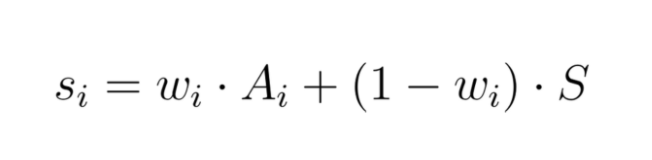

где 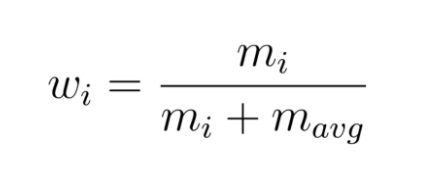

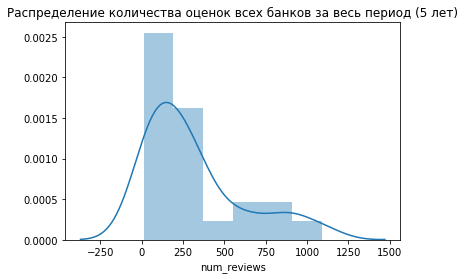

In [47]:
sns.distplot(ins_data['num_reviews']);
plt.title('Распределение количества оценок всех банков за весь период (5 лет)');

In [48]:
m_avg = ins_data['num_reviews'].median()
m_avg

215.5

In [49]:
m_i = ins_data['num_reviews']

In [50]:
ins_data['w'] = m_i/(m_i+m_avg)
w = ins_data['w']

In [51]:
S = ins_data['sum_rating'].sum()/ins_data['sum_time_koef'].sum()
S

4.277722785888445

In [52]:
A_i = ins_data['individual_rating']

In [53]:
ins_data['bayes_rating'] = (w * A_i 
                              + (1-w) * S
                             )

In [54]:
ins_data.sort_values('bayes_rating',ascending=False)
#banks_data.to_excel("output.xlsx")

,sum_rating,sum_time_koef,num_reviews,num_problem_solved,num_comp_resp,first_review_date,last_review_date,individual_rating,w,bayes_rating
organization_name,,,,,,,,,,
Югория,2791.944234,513.840485,882,37.0,684.0,2016-03-23,2021-03-16,5.433484,0.803645,5.206544
Ренессанс Страхование,1985.697442,399.748086,1090,212.0,1052.0,2016-03-17,2021-03-17,4.967372,0.834929,4.853531
Зетта Страхование,543.017046,103.947125,311,38.0,300.0,2016-03-20,2021-03-15,5.223974,0.590693,4.836667
Астро-Волга,768.844351,147.209453,238,31.0,226.0,2017-01-30,2021-03-12,5.222792,0.524807,4.773702
Абсолют Страхование,490.838321,92.567754,138,20.0,130.0,2017-03-22,2021-03-15,5.302476,0.390382,4.677768
Совкомбанк Страхование,126.668900,26.250306,89,17.0,75.0,2016-03-25,2021-02-27,4.825426,0.292282,4.437807
Согласие,596.777408,136.166202,442,46.0,387.0,2016-04-09,2021-03-16,4.382713,0.672243,4.348302
Манго,56.500000,11.000000,11,0.0,5.0,2020-09-20,2021-02-20,5.136364,0.048565,4.319423
Mafin,74.275577,17.787118,24,2.0,22.0,2019-12-26,2021-02-26,4.175807,0.100209,4.267510


ins_data.to_excel("InsC_bayes.xlsx")